In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
from datetime import date
from openpyxl import load_workbook
from itertools import combinations, product

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

In [3]:
Sudan_cities = pd.read_excel("./Sudan cities/Sudan_city_regions_2023-10-09.xlsx")

In [4]:
os.chdir("./Sudan cities/IOM reports/")

In [5]:
file_names = glob("*.xlsx")
file_names

['5_21.xlsx',
 '7_27.xlsx',
 '6_21.xlsx',
 '5_5.xlsx',
 '4_27.xlsx',
 '7_5.xlsx',
 '5_29.xlsx',
 '7_23.xlsx',
 '8_10.xlsx',
 '6_14.xlsx',
 '5_12.xlsx',
 '6_4.xlsx',
 '7_12.xlsx',
 '6_8.xlsx',
 '6_28.xlsx',
 '8_4.xlsx']

In [6]:
file_info_dict = {
    '4_27.xlsx': ['Dataset (27 April 2023)', 1, '#adm1+origin+name', '#adm1+name', '#affected+idps+ind'],
    '5_5.xlsx': ['5 May 2023 IDPs', 1, '#adm1+origin+name', '#adm1+name', '#affected+idps+ind'],
    '5_12.xlsx': ['Data_2023-05-12', 1, '#adm1+origin+name', '#adm1+name', '#affected+idps+ind'],
    '5_21.xlsx': ['IDPs 21 May 2023 Master Dataset', 6, '#adm1+origin+name', '#adm1+name', '#affected+idps+ind'],
    '5_29.xlsx': ['IDPs 26 May 2023 Master Datase ', 2, '#adm1+origin+name', '#adm1+name', '#affected+idps+ind'],
    '6_4.xlsx': ['(2 June 2023) IDP dataset', 1, '#adm1+origin+name', '#adm1+name', '#affected+idps+ind'],
    '6_8.xlsx': ['Master Dataset (8 June 2023)', 2, '#adm1+origin+name', '#adm1+name', '#affected+idps+ind'],
    '6_14.xlsx': ['Master IDP Dataset_14June2023', 2, '#adm1+origin+name', '#adm1+name', '#affected+idps+ind'],
    '6_21.xlsx': ['Master Dataset (21 June 2023)', 2, '#adm1+origin+name', '#adm1+name', '#affected+idps+ind'],
    '6_28.xlsx': ['Master Dataset (28 June 2023)', 2, '#adm1+origin+name', '#adm1+name', '#affected+idps+ind'],
    '7_5.xlsx': ['Master Dataset ( 05 July 2023)', 1, 'STATE ORIGIN', 'STATE OF DISPLACEMENT', 'IDPs'],
    '7_12.xlsx': ['Master Dataset ( 12 July 2023)', 3, '#adm1+origin+name', '#adm1+name', '#affected+idps+ind'],
    '7_23.xlsx': ['Master Dataset ( 19 July 2023)', 3, '#adm1+origin+name', '#adm1+name', '#affected+idps+ind'],
    '7_27.xlsx': ['Master Dataset (26-07-2023)', 3, '#adm1+origin+name', '#adm1+name', '#affected+idps+ind'],
    '8_4.xlsx': ['Master Dataset (02 Aug 2023)', 3, '#adm1+origin+name', '#adm1+name', '#affected+idps+ind'],
    '8_10.xlsx': ['Master Dataset (9 Aug 2023)', 2, '#adm1+origin+name', '#adm1+name', '#affected+idps+ind']
}

In [7]:
edge_df = pd.DataFrame()
for file_n, val in file_info_dict.items():
    iom_df = pd.read_excel(file_n, sheet_name=val[0], skiprows=val[1])
    month, day = [int(x) for x in file_n.strip(".xlsx").split("_")]
    iom_df['date'] = date(2023, month, day)
    edges = iom_df.groupby(['date', val[2], val[3]]).agg({val[4]:'sum'}).reset_index()
    edges.columns = ['date','from','to','val']
    edge_df = pd.concat([edge_df, edges])

In [8]:
edge_df.replace({'Gazera':'Aj Jazirah'}, inplace=True)
Sudan_states = set(edge_df['from'].tolist() + edge_df['to'].tolist())

In [9]:
set(Sudan_cities['Sudan_regions'].tolist()).symmetric_difference(Sudan_states)

set()

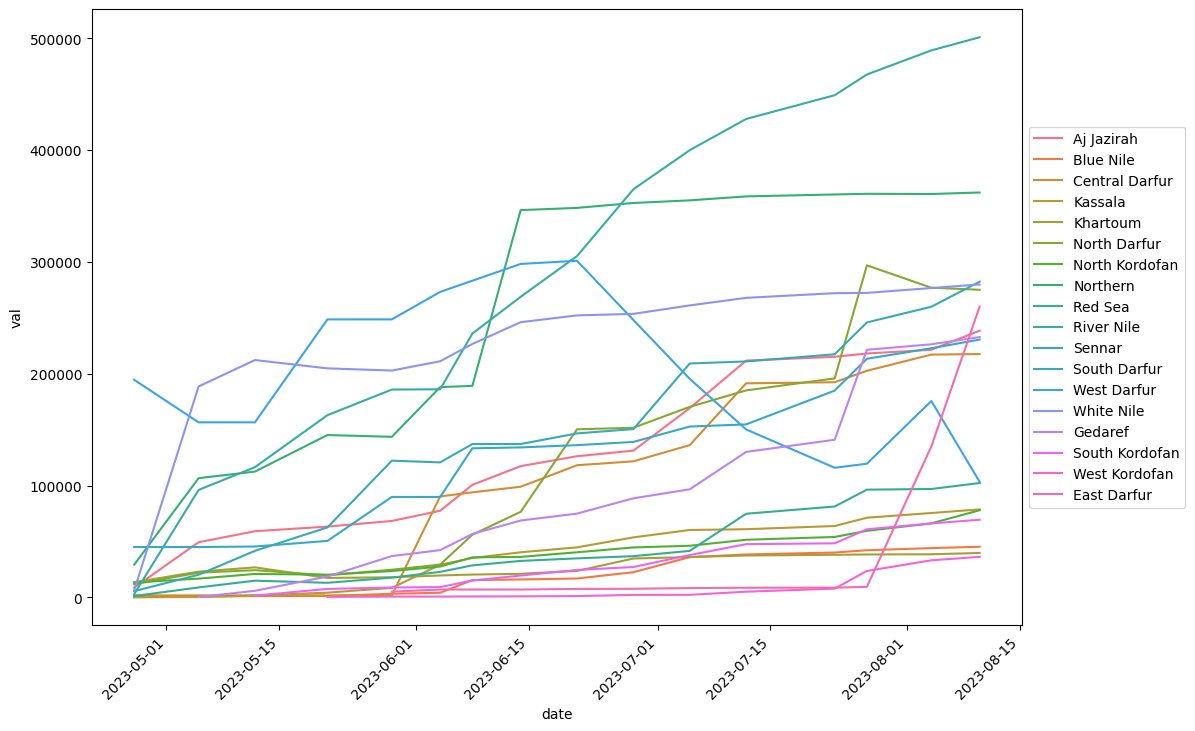

In [10]:
state_of_arrival = edge_df.groupby(['date','to']).agg({'val':'sum'}).reset_index()
sns.lineplot(x='date', y='val', hue='to', data=state_of_arrival)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

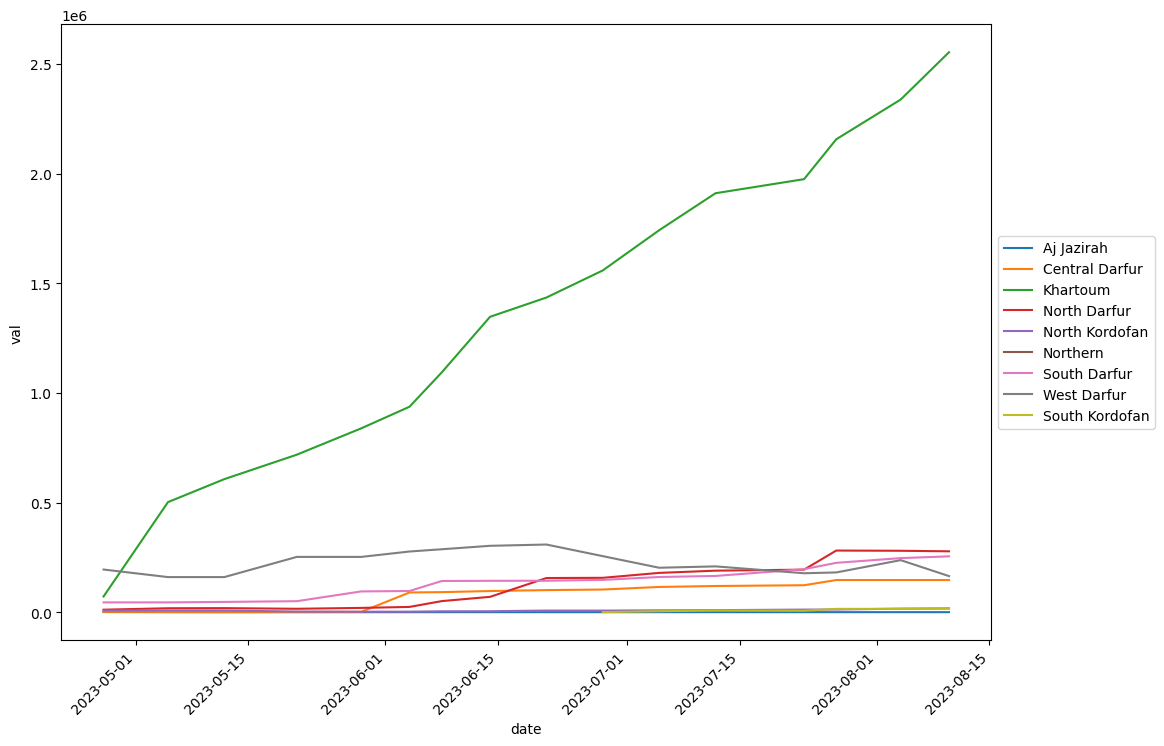

In [11]:
state_of_origin = edge_df.groupby(['date','from']).agg({'val':'sum'}).reset_index()
sns.lineplot(x='date', y='val', hue='from', data=state_of_origin)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [12]:
dates = sorted(edge_df['date'].unique())

In [13]:
def diff_date(d1, d2):
    df1 = edge_df.loc[edge_df['date']==d1,:]
    df2 = edge_df.loc[edge_df['date']==d2,:]
    df_merged = df1.merge(df2, how='outer', on=['from', 'to'], suffixes=('', '_later'))
    df_merged['val_delta'] = df_merged['val_later'] - df_merged['val']
    df_merged['days'] = (d2 - d1).days
    df_merged['date_later'].fillna(df_merged.loc[df_merged['date_later'].notnull(),'date_later'].values[0],
    inplace=True)
    return df_merged

In [14]:
diff_df = edge_df.loc[edge_df['date']==dates[0],['date', 'from', 'to', 'val']]
diff_df['days'] = (dates[0] - date(2023, 4, 15)).days
diff_df.columns = ['date_later', 'from', 'to', 'val_delta', 'days']

In [15]:
for d1, d2 in list(zip(dates[:-1], dates[1:])):
    diff_df = pd.concat([diff_df,
                         diff_date(d1, d2).loc[:,['date_later', 'from', 'to', 'val_delta', 'days']]],
                        axis=0)

In [16]:
diff_df['within_state'] = diff_df['from'] == diff_df['to']
diff_df.loc[(diff_df['val_delta']<0) & np.logical_not(diff_df['within_state']),:]

,date_later,from,to,val_delta,days,within_state
7,2023-05-21,Khartoum,North Darfur,-45.0,9,False
10,2023-05-21,Khartoum,Red Sea,-1911.0,9,False
14,2023-05-21,Khartoum,White Nile,-7444.0,9,False
8,2023-05-29,Khartoum,Northern,-1585.0,8,False
14,2023-05-29,Khartoum,White Nile,-1955.0,8,False
11,2023-06-04,Khartoum,Sennar,-1535.0,6,False
20,2023-06-21,South Darfur,East Darfur,-1730.0,7,False
23,2023-07-05,South Darfur,Central Darfur,-820.0,7,False
20,2023-07-23,North Darfur,Central Darfur,-500.0,11,False
20,2023-07-27,North Darfur,Central Darfur,-13500.0,4,False


In [17]:
edge_diff = pd.DataFrame(product(dates, Sudan_states, Sudan_states), columns=['date_later', 'from', 'to'])
edge_diff['within_state'] = edge_diff['from'] == edge_diff['to']
edge_diff['days'] =\
    edge_diff['date_later'].map(diff_df.groupby('date_later')['days'].unique().apply(lambda x: x[0]))
negative_merge = []
for i, lab in edge_diff.iterrows():
    m1 = diff_df['from'] == lab['from']
    m2 = diff_df['to'] == lab['to']
    m3 = diff_df['date_later'] == lab['date_later']
    if diff_df.loc[(m1 & m2 & m3),:].shape[0]==1:
        negative_merge.append(False)
    else:
        negative_merge.append(True)
edge_diff['fill_rows'] = negative_merge
edge_diff['fill_rows'].value_counts()

fill_rows
True     4731
False     453
Name: count, dtype: int64

In [18]:
full_edge = pd.concat([diff_df, edge_diff.loc[edge_diff['fill_rows'], ['date_later', 'from', 'to', 'days', 'within_state']]])

In [19]:
full_edge

,date_later,from,to,val_delta,days,within_state
0,2023-04-27,Aj Jazirah,Aj Jazirah,950.0,12,True
1,2023-04-27,Central Darfur,Central Darfur,1780.0,12,True
2,2023-04-27,Khartoum,Aj Jazirah,7845.0,12,False
3,2023-04-27,Khartoum,Kassala,95.0,12,False
4,2023-04-27,Khartoum,Khartoum,13545.0,12,True
...,...,...,...,...,...,...
5179,2023-08-10,White Nile,Central Darfur,NaN,6,False
5180,2023-08-10,White Nile,North Darfur,NaN,6,False
5181,2023-08-10,White Nile,West Darfur,NaN,6,False
5182,2023-08-10,White Nile,Kassala,NaN,6,False


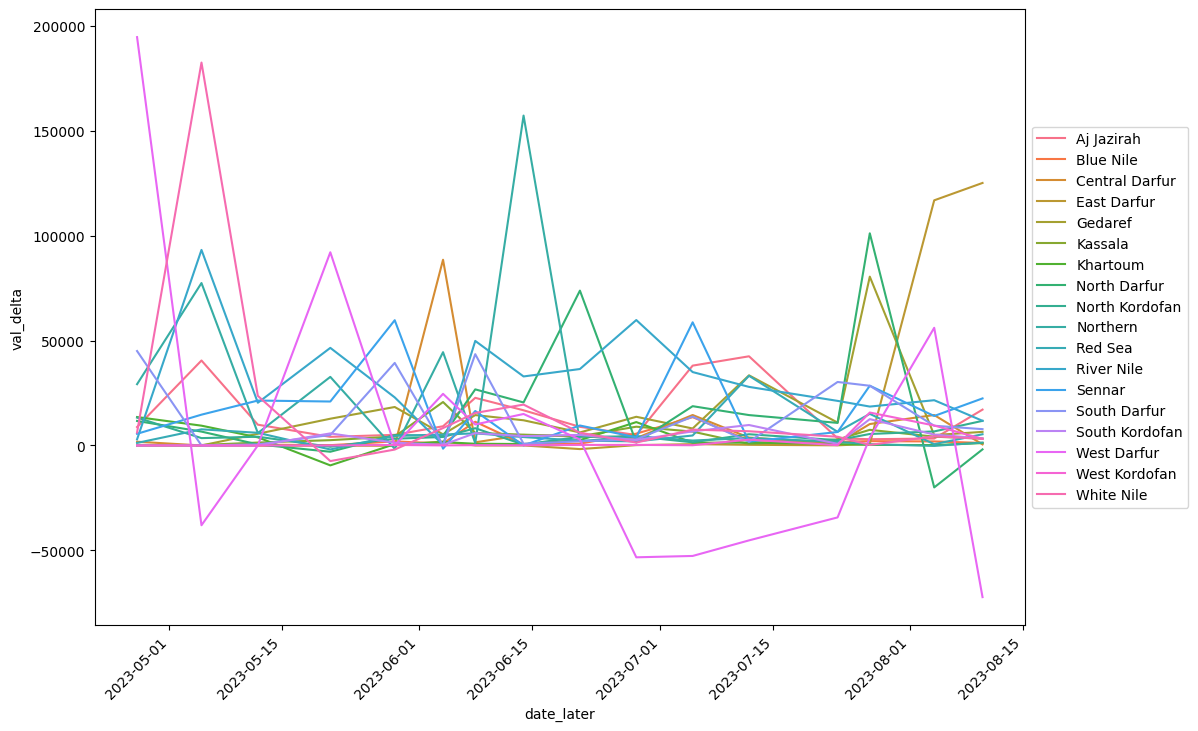

In [20]:
state_of_arrival = full_edge.groupby(['date_later','to']).agg({'val_delta':'sum'}).reset_index()
sns.lineplot(x='date_later', y='val_delta', hue='to', data=state_of_arrival)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

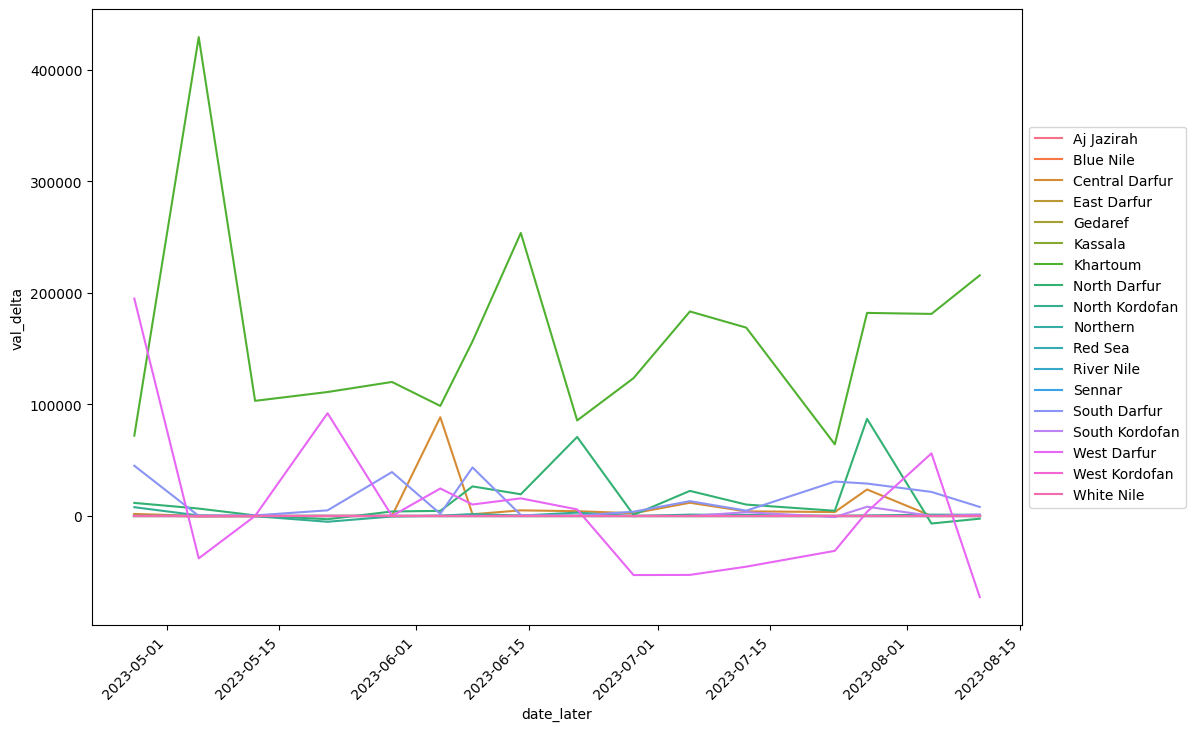

In [21]:
state_of_origin = full_edge.groupby(['date_later','from']).agg({'val_delta':'sum'}).reset_index()
sns.lineplot(x='date_later', y='val_delta', hue='from', data=state_of_origin)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [22]:
assert(full_edge['val_delta'].sum() == diff_df['val_delta'].sum())

In [23]:
full_edge.to_excel("../Sudan_states_edgelist_2023-10-12.xlsx", index=False)